In [15]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

import geopy
import geopandas

In [16]:
arrests = pd.read_csv('Arrests.csv')
arcgis_output = pd.read_csv('arrests-arcgis-output.csv', low_memory=False)

In [29]:
latlong = arcgis_output[['X', 'Y']]
df = pd.concat([arrests, latlong], axis=1)

In [31]:
df.head()

,ArrestID,ArrestDatetime,FirstName,HouseNumber,LastName,MiddleName,NameSuffix,Statute,StatuteDescription,Street,Race,Sex,X,Y
0,1001,2019-06-13T07:19:00.000Z,CHRISTOPHER,1505.0,STANLEY,DEAN,NaN,18.2-415,Disturbing the peace,UNIVERSITY AVE,Black,Female,-78.500668,38.035105
1,1002,2019-06-13T06:59:00.000Z,GABRIEL,109.0,SANTOS,J,NaN,18.2-388,PROFANE SWEARING OR INTOXICATION IN PUBLIC,CULBRETH RD,White,Male,-78.504152,38.039890
2,1003,2019-06-13T04:00:00.000Z,CAROLYN,350.0,RICE,PAIGE,NaN,18.2-111,Embezzlement,PARK ST,White,Female,-78.476634,38.031669
3,1004,2019-06-13T00:02:00.000Z,MICHAEL,7051.0,COOPER,JEROME,NaN,19.2-306,PROBATION VIOLATION - TYPE NOT CLEAR FROM RECORD,LOUISA RD,Black,Male,-78.477332,38.030289
4,1005,2019-06-12T18:15:00.000Z,Roy,606.0,Correll,Chapman,NaN,18.2-137(B)(i),"MONUMENT: INTENTIONAL DAMAGE, VALUE <$1000",E MARKET ST,White,Male,-78.477332,38.030289


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17380 entries, 0 to 17379
Data columns (total 14 columns):
ArrestID              17380 non-null int64
ArrestDatetime        17380 non-null object
FirstName             17378 non-null object
HouseNumber           15450 non-null float64
LastName              17380 non-null object
MiddleName            16236 non-null object
NameSuffix            1610 non-null object
Statute               17362 non-null object
StatuteDescription    17362 non-null object
Street                16497 non-null object
Race                  17363 non-null object
Sex                   17372 non-null object
X                     17380 non-null float64
Y                     17380 non-null float64
dtypes: float64(3), int64(1), object(10)
memory usage: 1.9+ MB


To convert the date, we will split it into two columns. One will be a float64 in units of months (do we ignore the year?). The other will be a float64 in units of hours.

In [11]:
def null_values(df, return_table=True):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * mis_val / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(4)
    print("There are", len(df.columns), "columns in total.")
    print("There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
    if return_table:
        return mis_val_table_ren_columns

The only nonmissing features are the ID, the date and time, and the last name.

In [34]:
miss_values = null_values(arrests)
pd.set_option('display.max_rows', None)
miss_values

There are 12 columns in total.
There are 9 columns that have missing values.


,Missing Values,% of Total Values
NameSuffix,15770,90.7365
HouseNumber,1930,11.1047
MiddleName,1144,6.5823
Street,883,5.0806
Statute,18,0.1036
StatuteDescription,18,0.1036
Race,17,0.0978
Sex,8,0.0460
FirstName,2,0.0115


To impute missing data in 'Sex', all nan values should be replaced with 'Unknown'.

In [7]:
arrests['Sex'].unique()

array(['Female', 'Male', nan, 'Unknown'], dtype=object)

The two rows without first names are interesting. In the row with ID 2262, the last name is a placeholder 'JOHN DOE'.

In [23]:
arrests.loc[arrests['FirstName'] != arrests['FirstName']]

,ArrestID,ArrestDatetime,FirstName,HouseNumber,LastName,MiddleName,NameSuffix,Statute,StatuteDescription,Street,Race,Sex
696,1697,2019-03-15T00:38:00.000Z,NaN,NaN,PURPLERAIN,NaN,NaN,905,DRUNKENESS,BROWN ST,Black,Female
5261,2262,2018-12-24T13:06:00.000Z,NaN,1131.0,JOHN DOE,NaN,NaN,18.2-388,PROFANE SWEARING OR INTOXICATION IN PUBLIC,5TH ST SW,White,Male


What are 'nwt', 'doc', and 'jpg' doing in the 'Race' feature?

In [ ]:
arrests.loc[arrests['Race'] == 'nwt']

In [ ]:
arrests.loc[arrests['Race'] == 'doc']

We see that there are multiple descriptions that correspond to the same statute. Therefore, we drop the StatuteDescription feature because it does not add anything to the data.

If we keep the names, it is reasonable to perform feature engineering that assigns a unique number to a full name, including the suffix if applicable, since we see that one person can and often commits more than one offense. We will have to convert every name to uppercase, since the capitalization is inconsistent.

There are 472 unique statutes. A OneHotEncoder will result in the number of features increasing to about 480.

In [24]:
arrests['NameSuffix'].unique()

array([nan, 'Jr', 'II', 'III', 'Sr', 'IV'], dtype=object)

In [ ]:
arrests['StatuteDescription'].value_counts()

In [ ]:
arrests['Statute'].value_counts()

In [19]:
arrests['Statute'].nunique()

472

## Data cleaning

We drop the ArrestID and StatuteDescription because the former is useless and the latter is redundant with Statute. In fact, there are many descriptions that can potentially refer to the same statute. We also drop the names since there are too many unique names for an analysis to be useful with them kept.

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

In [3]:
arrests = pd.read_csv('Arrests.csv')
arcgis_output = pd.read_csv('arrests-arcgis-output.csv', low_memory=False)

In [4]:
latlong = arcgis_output[['X', 'Y']]
df = pd.concat([arrests, latlong], axis=1)

In [5]:
useless_and_redundant = ['ArrestID', 'StatuteDescription']
names = ['FirstName', 'LastName', 'MiddleName', 'NameSuffix']
df.drop(useless_and_redundant, axis=1, inplace=True)
df.drop(names, axis=1, inplace=True)

In [6]:
df['Year'] = pd.to_datetime(df['ArrestDatetime']).apply(
    lambda x: float(x.strftime('%Y')) if x == x else np.nan)
df['Month'] = pd.to_datetime(df['ArrestDatetime']).apply(
    lambda x: float(x.strftime('%m')) if x == x else np.nan) 
df['Time'] = pd.to_datetime(df['ArrestDatetime']).apply(
    lambda x: float(x.strftime('%H')) + 1/60 * float(x.strftime('%M')) + 1/3600 * float(x.strftime('%S'))
    if x == x else np.nan)

In [7]:
df.drop(['ArrestDatetime', 'HouseNumber', 'Street'], axis=1, inplace=True)

We will use OneHotEncoding for race and sex.

In [8]:
onehot = OneHotEncoder()

def convert_races(x):
    if x == 'Unknown' or x == 'nwt' or x == 'doc' or x == 'jpg' or x != x:
        return 'Unknown Race'
    else:
        return x

def convert_sex(x):
    if x == 'Unknown' or x != x:
        return 'Unknown Sex'
    else:
        return x
    
df['Race'] = df['Race'].apply(convert_races)    
df['Sex'] = df['Sex'].apply(convert_sex)

cat_onehot = df[['Race', 'Sex']]
mtx_onehot = onehot.fit_transform(cat_onehot).toarray()
df_onehot = pd.DataFrame(mtx_onehot, columns=np.concatenate(onehot.categories_))
df.drop(['Race', 'Sex'], axis=1, inplace=True)
df = pd.concat([df, df_onehot], axis=1)

In [9]:
df.head()

,Statute,X,Y,Year,Month,Time,American Indian/Alaskan Native,Asian or Pacific Islander,Black,Unknown Race,White,Female,Male,Unknown Sex
0,18.2-415,-78.500668,38.035105,2019.0,6.0,7.316667,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,18.2-388,-78.504152,38.039890,2019.0,6.0,6.983333,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,18.2-111,-78.476634,38.031669,2019.0,6.0,4.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,19.2-306,-78.477332,38.030289,2019.0,6.0,0.033333,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,18.2-137(B)(i),-78.477332,38.030289,2019.0,6.0,18.250000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [12]:
miss_values = null_values(df)
pd.set_option('display.max_rows', None)
miss_values

There are 14 columns in total.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
Statute,18,0.1036


We shall remove those entries with missing statutes.

In [13]:
df.dropna(subset=['Statute'], how='any', inplace=True)

In [14]:
miss_values = null_values(df)
pd.set_option('display.max_rows', None)
miss_values

There are 14 columns in total.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


To deal with the cyclical features Month and Time, we take the sine and cosine with period 12 and 24, respectively.

In [15]:
df['Month_Cos'] = np.cos((df['Month'] - 1) * (2*np.pi/12))
df['Month_Sin'] = np.sin((df['Month'] - 1) * (2*np.pi/12))
df['Time_Cos'] = np.cos(df['Time']* (2*np.pi/24))
df['Time_Sin'] = np.sin(df['Time']* (2*np.pi/24))
df.drop(['Month', 'Time'], axis=1, inplace=True)

In [23]:
df.head()

,X,Y,Year,American Indian/Alaskan Native,Asian or Pacific Islander,Black,Unknown Race,White,Female,Male,Unknown Sex,Month_Cos,Month_Sin,Time_Cos,Time_Sin
0,-78.500668,38.035105,2019.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.866025,0.5,-0.337917,0.941176
1,-78.504152,38.039890,2019.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.866025,0.5,-0.254602,0.967046
2,-78.476634,38.031669,2019.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-0.866025,0.5,0.500000,0.866025
3,-78.477332,38.030289,2019.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.866025,0.5,0.999962,0.008727
4,-78.477332,38.030289,2019.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.866025,0.5,0.065403,-0.997859


Let us keep only those rows where the coordinates are inside of a box defined by in_long and in_lat. Outside refers to locations that are not in Charlottesville.

In [16]:
in_long = (-78.60 < df['X']) & (df['X'] < -78.40)
in_lat  = (+37.95 < df['Y']) & (df['Y'] < +38.15)
df = df[in_long & in_lat]

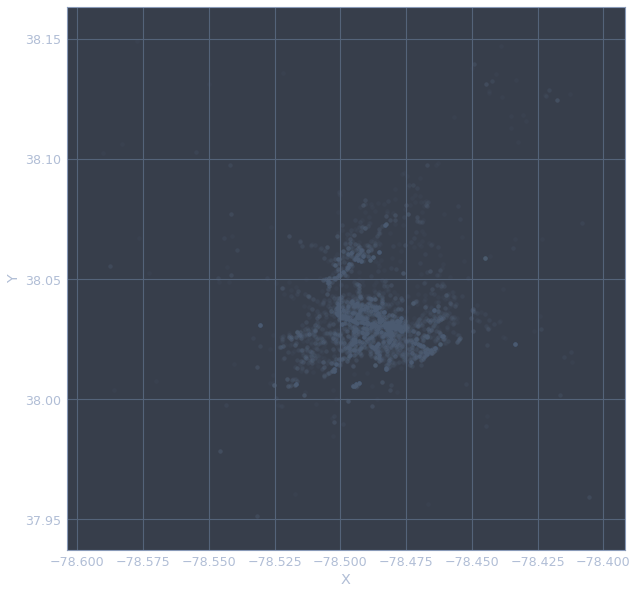

In [17]:
df.plot(kind="scatter", x='X', y='Y', alpha=0.1, figsize=(10, 10));

For the purposes of clustering, let us first drop the statutes column, and focus on the features time, race, and gender first.

In [18]:
df.drop(['Statute'], axis=1, inplace=True)

In [19]:
pipeline = Pipeline([
    ('scaler', StandardScaler())
])

In [20]:
df_scaled = pipeline.fit_transform(df)

In [21]:
from sklearn.cluster import KMeans

Text(0, 0.5, 'Inertia')

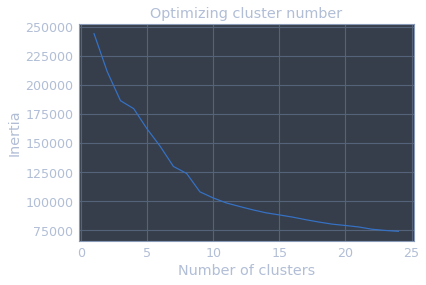

In [29]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_scaled) for k in range(1, 25)]
inertias = [model.inertia_ for model in kmeans_per_k]
plt.plot(range(1, 25), inertias)
plt.title("Optimizing cluster number")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia");

In [30]:
from sklearn.metrics import silhouette_score

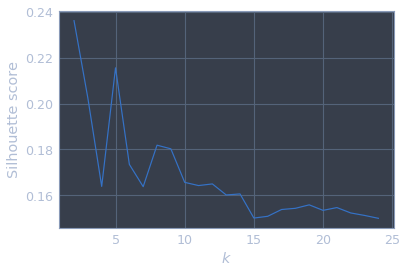

In [31]:
silhouette_scores = [silhouette_score(df_scaled, model.labels_) for model in kmeans_per_k[1:]]
plt.plot(range(2, 25), silhouette_scores)
plt.xlabel("$k$")
plt.ylabel("Silhouette score");

In [32]:
pd.DataFrame(pipeline.inverse_transform(kmeans_per_k[9].cluster_centers_), columns=df.columns)

,X,Y,Year,American Indian/Alaskan Native,Asian or Pacific Islander,Black,Unknown Race,White,Female,Male,Unknown Sex,Month_Cos,Month_Sin,Time_Cos,Time_Sin
0,-78.484679,38.028581,2016.608576,4.553649e-18,-5.898060e-17,3.574918e-14,-6.643991e-16,1.000000e+00,5.384582e-15,1.000000e+00,2.211772e-17,-0.037584,0.043436,-0.075034,-0.718683
1,-78.486371,38.028513,2016.821285,-5.193328e-17,-5.984796e-17,1.000000e+00,-8.881784e-16,-2.814415e-14,1.618150e-14,1.000000e+00,-1.951564e-17,-0.482816,0.434644,0.129162,-0.185562
2,-78.488668,38.030441,2016.664372,-1.767250e-17,-5.898060e-17,3.830269e-14,-7.528700e-16,1.000000e+00,9.603429e-15,1.000000e+00,1.279359e-17,-0.032794,-0.044734,0.415393,0.589817
3,-78.486234,38.029840,2016.640878,1.019150e-17,-5.724587e-17,2.586820e-14,-3.330669e-16,1.000000e+00,1.000000e+00,-1.965095e-14,1.723881e-17,0.000253,0.009861,0.150439,-0.158077
4,-78.487602,38.029326,2016.490774,-3.881444e-17,-5.984796e-17,1.000000e+00,-8.378714e-16,-2.098322e-14,1.365574e-14,1.000000e+00,-7.155734e-18,0.456865,-0.465953,0.156334,-0.117059
5,-78.490766,38.029539,2017.178947,-2.168404e-19,1.000000e+00,0.000000e+00,6.938894e-18,-2.775558e-16,1.263158e-01,8.736842e-01,9.757820e-19,0.129514,-0.022463,0.199937,0.131154
6,-78.488092,38.031883,2017.545455,1.000000e+00,-8.673617e-19,0.000000e+00,-1.734723e-18,-1.110223e-16,2.775558e-17,1.000000e+00,0.000000e+00,0.042191,0.090909,0.639767,-0.238383
7,-78.498515,38.028407,2018.777778,-1.084202e-19,0.000000e+00,1.111111e-01,8.888889e-01,-5.551115e-17,-2.775558e-17,0.000000e+00,1.000000e+00,-0.688461,0.525783,0.791901,0.397978
8,-78.487118,38.030095,2016.870748,-2.168404e-19,-1.561251e-17,0.000000e+00,1.000000e+00,-1.054712e-15,4.353741e-01,5.646259e-01,1.084202e-18,-0.085636,0.010937,0.274937,-0.059482
9,-78.486853,38.029085,2016.701604,1.019150e-17,-5.724587e-17,1.000000e+00,-3.417405e-16,1.088019e-14,1.000000e+00,-1.965095e-14,1.723881e-17,-0.080519,0.020797,0.142956,-0.230011


In [33]:
kmeans_per_k[9].inertia_

102846.03858781612